In [1]:
library(Seurat)
library(dplyr)
library(ggplot2)
inputdir <- "./load_files/"
outputdir <- "./report/"

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
reg_ord <- c("MFC","OFC","DFC","VFC","M1C","S1C","IPC","PCC","V1C","Insula","A1C","STC","ITC")
all_pairs <- combn(reg_ord, 2)

data_e93 <- lapply(1:ncol(all_pairs), function(x) {
    reg1 <- all_pairs[1, ][x]
    reg2 <- all_pairs[2, ][x]
    
    if (file.exists(paste0(inputdir, "Augur_res/Augur_rawRes_E93.", reg1, ".", reg2, ".rds"))){
        augres <- readRDS(file = paste0(inputdir, "Augur_res/Augur_rawRes_E93.", reg1, ".", reg2, ".rds"))$AUC
    } else {
        augres <- readRDS(file = paste0(inputdir, "Augur_res/Augur_rawRes_E93.", reg2, ".", reg1, ".rds"))$AUC
    }
    
    augres <- augres %>%
                mutate(region1 = reg1, region2 = reg2, age = "E93")
    return(augres)
    }) %>%
    do.call(rbind, .)
summary(data_e93)
data_e110 <- lapply(1:ncol(all_pairs), function(x) {
    reg1 <- all_pairs[1, ][x]
    reg2 <- all_pairs[2, ][x]
    
    if (file.exists(paste0(inputdir, "Augur_res/Augur_rawRes_E110.", reg1, ".", reg2, ".rds"))){
        augres <- readRDS(file = paste0(inputdir, "Augur_res/Augur_rawRes_E110.", reg1, ".", reg2, ".rds"))$AUC
    } else {
        augres <- readRDS(file = paste0(inputdir, "Augur_res/Augur_rawRes_E110.", reg2, ".", reg1, ".rds"))$AUC
    }
    
    augres <- augres %>% 
                mutate(region1 = reg1, region2 = reg2, age = "E110")
    return(augres)
    }) %>%
    do.call(rbind, .)
summary(data_e110)
pdata <- rbind(data_e93, data_e110) %>%
        mutate(region1 = factor(region1, levels = reg_ord)) %>%
        mutate(region2 = factor(region2, levels = reg_ord)) %>%
        mutate(auc = MinMax(auc, min = 0.5, max = 0.9))

  cell_type              auc           region1            region2         
 Length:156         Min.   :0.5435   Length:156         Length:156        
 Class :character   1st Qu.:0.6364   Class :character   Class :character  
 Mode  :character   Median :0.6770   Mode  :character   Mode  :character  
                    Mean   :0.6764                                        
                    3rd Qu.:0.7155                                        
                    Max.   :0.8287                                        
     age           
 Length:156        
 Class :character  
 Mode  :character  
                   
                   
                   

  cell_type              auc           region1            region2         
 Length:156         Min.   :0.5422   Length:156         Length:156        
 Class :character   1st Qu.:0.6304   Class :character   Class :character  
 Mode  :character   Median :0.6764   Mode  :character   Mode  :character  
                    Mean   :0.6870                                        
                    3rd Qu.:0.7379                                        
                    Max.   :0.8969                                        
     age           
 Length:156        
 Class :character  
 Mode  :character  
                   
                   
                   

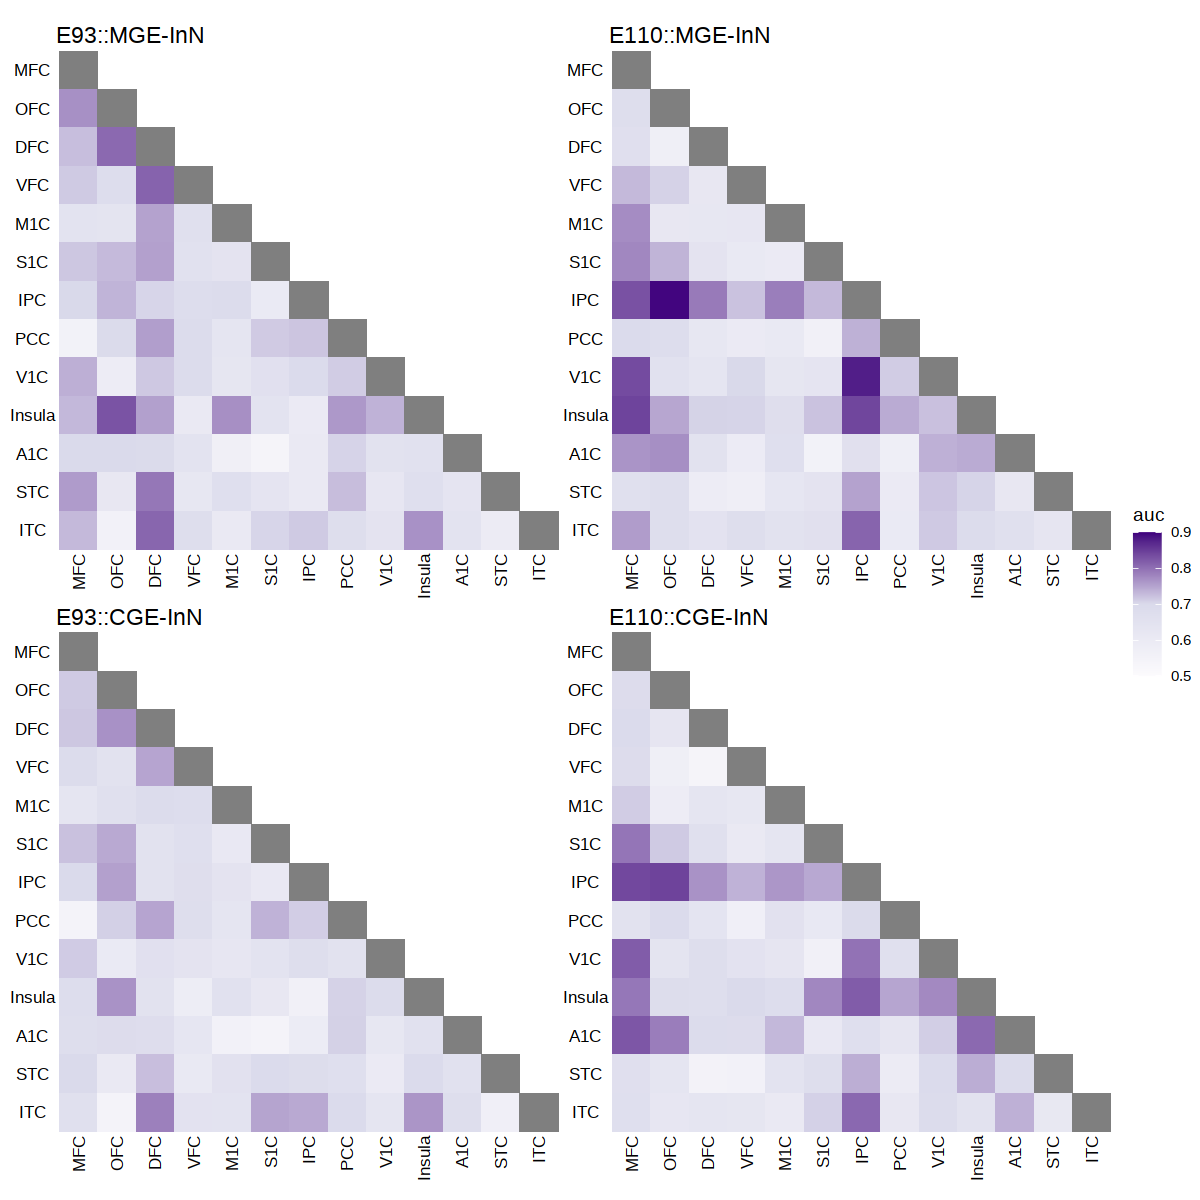

In [3]:
## Plot half heatmap
plist <- lapply(c("MGE-InN", "CGE-InN"), function(gp) {
    agelist <- lapply(c("E93", "E110"), function(ag) {
        subdata <- filter(pdata, cell_type == gp & age == ag)

        ## Transform the data to a triangle data
        mat <- matrix(0, nrow = length(reg_ord), ncol = length(reg_ord), dimnames = list(reg_ord, reg_ord))
        for (i in 1:nrow(subdata)){
            reg1 <- subdata$region1[i]
            reg2 <- subdata$region2[i]
            mat[reg1, reg2] <- subdata$auc[i]
            mat[reg2, reg1] <- subdata$auc[i]
        }
        mat[lower.tri(mat, diag = FALSE)] <- NA
        ndata <- mat %>%
                reshape2::melt() %>%
                setNames(., c("region1", "region2", "auc")) %>%
                mutate(region1 = factor(as.character(region1), levels = reg_ord)) %>%
                mutate(region2 = factor(as.character(region2), levels = rev(reg_ord))) %>%
                filter(!is.na(auc))
        ndata$auc[ndata$auc == 0] <- NA

        p <- ggplot(ndata, aes(x = region1, y = region2, fill = auc)) +
                geom_tile(color = NA) +
                theme_void()+
                coord_fixed() +
                labs(title = paste0(ag, "::", gp)) +
                scale_fill_gradientn(colors = c("#fcfbfd", "#dadaeb", "#3f007d"), limits = c(0.5, 0.9)) +
                theme(legend.position = "right", axis.text.y = element_text(size = rel(0.9)), 
                    axis.text.x = element_text(size = rel(0.9), angle = 90, hjust = 1))
        return(p)
        })
    return(agelist)
    }) %>%
    do.call(c, .)
pcbn <- patchwork::wrap_plots(plist, nrow = 2, ncol = 2, guides = "collect") & theme(legend.position = "right")
options(repr.plot.width=10, repr.plot.height=10)
pcbn

In [4]:
pdf(paste0(outputdir, "Augur_results_v2.pdf"), width = 10, height = 10)
print(pcbn)
dev.off()

png 
  2

In [5]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS/LAPACK: /gpfs/gibbs/pi/sestan.ycga/sm2726/Tools/Anaconda3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.0 dplyr_1.0.7   Seurat_3.1.5 

loaded via a namespace (and not attached):
 [1] nlme_3.1-147        tsne_0.1-3          RcppAnnoy_0.0.16   
 [4] RColorBrewer_1.1-2  httr_1.4.1          repr_1.1.6         
 [7] sctransform_0.2.1   tools_3.6.1     